In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from multiprocessing import get_context
from multiprocessing import Process

In [2]:
BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'

In [3]:
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

In [4]:
def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

In [5]:
def get_all_files_of_type(BIDS_path, type_='.vhdr'):
    """
    
    Given a BIDS path return all vhdr file paths without BIDS_Layout
    Args:
        BIDS_path (string)
    Returns: 
        vhdr_files (list)
    """
    vhdr_files = []
    for root, dirs, files in os.walk(BIDS_path):
        for file in files:
            if file.endswith(type_):
                vhdr_files.append(os.path.join(root, file))
    return vhdr_files

In [6]:
vhdr_files = get_all_files_of_type(BIDS_path, '.vhdr')
tsv_files = get_all_files_of_type(BIDS_path, '.tsv')

In [7]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx


In [8]:
def calc_epochs(bv_raw, y_tr, info, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    bv_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2)])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    n_epochs = bv_epoch.shape[0]
    events = np.empty((n_epochs, 3), dtype=int)


    event_id = dict(mov_present=1)

    for idx, i in enumerate(ind_mov):
        bv_epoch[idx,:] = bv_raw[i-epoch_lim:i+epoch_lim]
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]
        events[idx,:] = i, 0, event_id["mov_present"]
    print(bv_epoch.shape)
    bv_epoch = np.expand_dims(bv_epoch, axis=1)
    print(bv_epoch.shape)
    epochs = EpochsArray(data=bv_epoch, info=info, events=events, event_id=event_id)
    return epochs

In [9]:
def load_concat_dat(subject_id_, tsv_files, vhdr_files, best_ch, Con_, ECOG_):
    """
    This function loads a resulting downsampeled and direct channel cross validated JSON output file 
    From this file the best resulting channel is read 
    According to this channel all raw BIDS run files are searched for that channel 
    Given if this channel contra/ipsilateral the data/movement will concatenated and returned
    :param subject_id_ used BIDS subject id in shape '000'
    :param tsv_files: all TSV Files in the given BIDS folder
    """

    if best_ch == 'STN_LEFT_3':
        best_ch = 'STN_LEFT_2'
    if best_ch == 'STN_RIGHT_3':
        best_ch = 'STN_RIGHT_2'
    
    print(best_ch)
    if 'RIGHT' in best_ch:
        ses_patient = 'right'
    elif 'LEFT' in best_ch :
        ses_patient = 'left'
    
    #ses_ = []
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-right')) is True:
    #    ses_.append('right')
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-left')) is True:
    #    ses_.append('left')
    #print(ses_patient)
    runs_ = [file for file in tsv_files if 'sub-'+subject_id_ in file and 'ses-'+ses_patient in file and file.endswith('channels.tsv')]
    start = 0
    #print(runs_)
    for run in runs_:
        #print(run)
        df_run = pd.read_csv(run, sep="\t")
        if best_ch in list(df_run['name']):
            ind_data = np.where(df_run['name'] == best_ch)[0][0]
            run_number = run[run.find('run-')+4:run.find('_channels')] # is a string
            
            vhdr_file = 'sub-'+subject_id_+'_ses-'+ses_patient+'_task-force_run-'+str(run_number)+'_eeg.vhdr'
            vhdr_path = [file for file in vhdr_files if vhdr_file in file][0]
                
            #print(vhdr_path)
            
            bv_raw, ch_names = read_BIDS_file(vhdr_path)

            ind_mov = [ch_idx for ch_idx, ch in enumerate(ch_names) if ch.startswith('MOV') or ch.startswith('ANALOG')]

            # approach only indexing ECOG named channels
            ind_dat = np.arange(bv_raw.shape[0])[~np.isin(np.arange(bv_raw.shape[0]), ind_mov)]
            
            #print(ind_mov)
            mov_label = bv_raw[ind_mov, :] 
            
            #print(ch_names)
            mov_channels = list(np.array(ch_names)[ind_mov])
            
            mov_idx = get_movement_idx(best_ch, mov_channels, Con=Con_)
            
            print('best_ch: '+str(best_ch))
            print('mov_channels: '+str(mov_channels))
            print('mov_idx: '+str(mov_idx))
            label_ = mov_label[mov_idx,:]

            if start == 0: 
                start = 1 
                ch_dat = bv_raw[ind_data,:]
                mov_dat = label_
            else:
                ch_dat = np.concatenate((ch_dat, bv_raw[ind_data,:]), axis=0)
                mov_dat = np.concatenate((mov_dat, label_), axis=0)
    return ch_dat, mov_dat


In [10]:
def mutliprocess_tf(ch):
    print('subject: '+str(subject_id_)+ ' channel: '+str(ch))

    # z-score mov_dat and then apply the threshold 
    
    ch_dat, mov_dat = load_concat_dat(subject_id_, tsv_files, vhdr_files, ch, Con_, ECOG_)
    
    mov_dat = scipy.stats.zscore(mov_dat, axis=0)
    info = create_info(ch_names=[ch], sfreq=1000, ch_types='ecog')
    epochs = calc_epochs(ch_dat, mov_dat, info, threshold=1.5, epoch_lim=2500)


    freqs = np.arange(7, 200, 1)
    power = tfr_morlet(epochs, freqs=freqs,
                           n_cycles=5, return_itc=False, zero_mean=True, picks=0)
    dat = power.data[0,:,500:4500]  # cut off borders due to Wavelet transform
    dat_z = scipy.stats.zscore(dat, axis=1)
    
    print('hallo!')
    np.save('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\ECOG_'+str(ECOG_)+'_Con_'+str(Con_)+\
           '_sub_'+str(subject_id_)+'_ch_'+str(ch)+'.npy', dat_z)

In [11]:
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  64


In [27]:
from multiprocessing import Pool

In [30]:
Con_ = False
ECOG_ = True
n_cycles = 5

for _, subject_id_ in enumerate(subject_id):
    if Con_ is False and subject_id_ == '013':
        continue
    print(subject_id_)
    out_path = 'C:\\Users\\ICN_admin\\Documents\\Ubuntu_SAVE\\Documents\\raw_out\\LM_100ms\\'
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    channels = list(dict_ch.keys())
    for ch in channels:
        if ECOG_ is True and 'ECOG' in ch:
            mutliprocess_tf(ch)
        elif ECOG_ is False and 'STN' in ch:
            mutliprocess_tf(ch)
    #with Pool(processes=64) as pool:
    #    pool.map(mutliprocess_tf, list(dict_ch.keys()))

000
subject: 000 channel: ECOG_RIGHT_0
ECOG_RIGHT_0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-000\ses-right\eeg\sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-000\ses-right\eeg\sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-000\ses-right\eeg\sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-000\ses-right\eeg\sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0


Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(125, 5000)
(125, 1, 5000)
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG_RIGHT_2
ECOG_RIGHT_2
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_2
mov_channels: ['MOV_RIG

Setting channel info structure...
best_ch: ECOG_RIGHT_10
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_10
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(125, 5000)
(125, 1, 5000)
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG_RIGHT_11
ECOG_RIGHT_11
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_11
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_11
mov_channels: ['M

Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(125, 5000)
(125, 1, 5000)
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG_RIGHT_20
ECOG_RIGHT_20
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_20
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-right\eeg\sub-001_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_20
mov_channels: ['M

Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
121 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG_LEF

Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
121 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG_LEF

Setting channel info structure...
best_ch: ECOG_LEFT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
121 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG

Setting channel info structure...
best_ch: ECOG_LEFT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
121 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG

Setting channel info structure...
best_ch: ECOG_LEFT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-001\ses-left\eeg\sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
121 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 001 channel: ECOG

Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(56, 5000)
(56, 1, 5000)
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 004 channel: ECOG_RIGHT_5
ECOG_RIGHT_5
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-004\ses-right\eeg\sub-004_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-004\ses-right\eeg\sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(56, 5000)
(56, 1, 5000)
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 004 channel: ECOG_RIGHT_6
ECOG_RIGHT_6
Extra

Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(42, 5000)
(42, 1, 5000)
42 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 005 channel: ECOG_RIGHT_6
ECOG_RIGHT_6
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-005\ses-right\eeg\sub-005_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(42, 5000)
(42, 1, 5000)
42 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 005 channel: ECOG_RIGHT_7
ECOG_RIGHT_7
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-005\ses-right\eeg\sub-005_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(42, 

best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-005\ses-left\eeg\sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-005\ses-left\eeg\sub-005_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-005\ses-left\eeg\sub-005_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(97, 5000)
(97, 1, 5000)
97 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 005 channel: ECOG_LEFT_7
ECOG_LEFT_7
Extracting parameters

Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(104, 5000)
(104, 1, 5000)
104 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_RIGHT_6
ECOG_RIGHT_6
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_6
mov_channels: ['MOV_RIG

Setting channel info structure...
best_ch: ECOG_RIGHT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(104, 5000)
(104, 1, 5000)
104 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_RIGHT_13
ECOG_RIGHT_13
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_13
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_13
mov_channels: ['M

Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(104, 5000)
(104, 1, 5000)
104 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_RIGHT_20
ECOG_RIGHT_20
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_20
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_20
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_20
mov_channels: ['M

No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_RIGHT_27
ECOG_RIGHT_27
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_27
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_27
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_27
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-right\eeg\sub-006_ses-right_task-force_run-6_eeg.vhdr.

Setting channel info structure...
best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_LEFT_4
ECOG_LEFT_4
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT'

best_ch: ECOG_LEFT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_LEFT_13
ECOG_LEFT_13
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_13
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_13
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_13
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85,

best_ch: ECOG_LEFT_21
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_LEFT_22
ECOG_LEFT_22
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_22
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_22
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_22
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85,

best_ch: ECOG_LEFT_30
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 006 channel: ECOG_LEFT_31
ECOG_LEFT_31
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_31
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_31
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-006\ses-left\eeg\sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_31
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85,

Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(87, 5000)
(87, 1, 5000)
87 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 008 channel: ECOG_LEFT_2
ECOG_LEFT_2
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-008\ses-left\eeg\sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-008\ses-left\eeg\sub-008_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(87, 5000)
(87, 1, 5000)
87 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 008 channel: ECOG_LEFT_3
ECOG_LEFT_3
Extracting param

Setting channel info structure...
best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(53, 5000)
(53, 1, 5000)
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 009 channel: ECOG_LEFT_4
ECOG_LEFT_4
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-009\ses-left\eeg\sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-009\ses-left\eeg\sub-009_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-009\ses-left\eeg\sub-009_ses-left_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT'

Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-8_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(205, 5000)
(205, 1, 5000)
205 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
hallo!
subject: 010 channel: ECOG_LEFT_1
ECOG_LEFT_1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LE

Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-010\ses-left\eeg\sub-010_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_chann

In [31]:
files = os.listdir('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\')
files_ECOG_Con = [file for file in files if 'ECOG_True' in file and 'Con_True' in file]
l = []
for file in files_ECOG_Con:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
ECOG_CON = np.array(l).mean(axis=0)

files_ECOG_Ips = [file for file in files if 'ECOG_True' in file and 'Con_False' in file]
l = []
for file in files_ECOG_Ips:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
ECOG_Ips = np.array(l).mean(axis=0)

files_STN_Con = [file for file in files if 'ECOG_False' in file and 'Con_True' in file]
l = []
for file in files_STN_Con:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
STN_CON = np.array(l).mean(axis=0)

files_STN_Ips = [file for file in files if 'ECOG_False' in file and 'Con_False' in file]
l = []
for file in files_STN_Ips:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
STN_Ips = np.array(l).mean(axis=0)


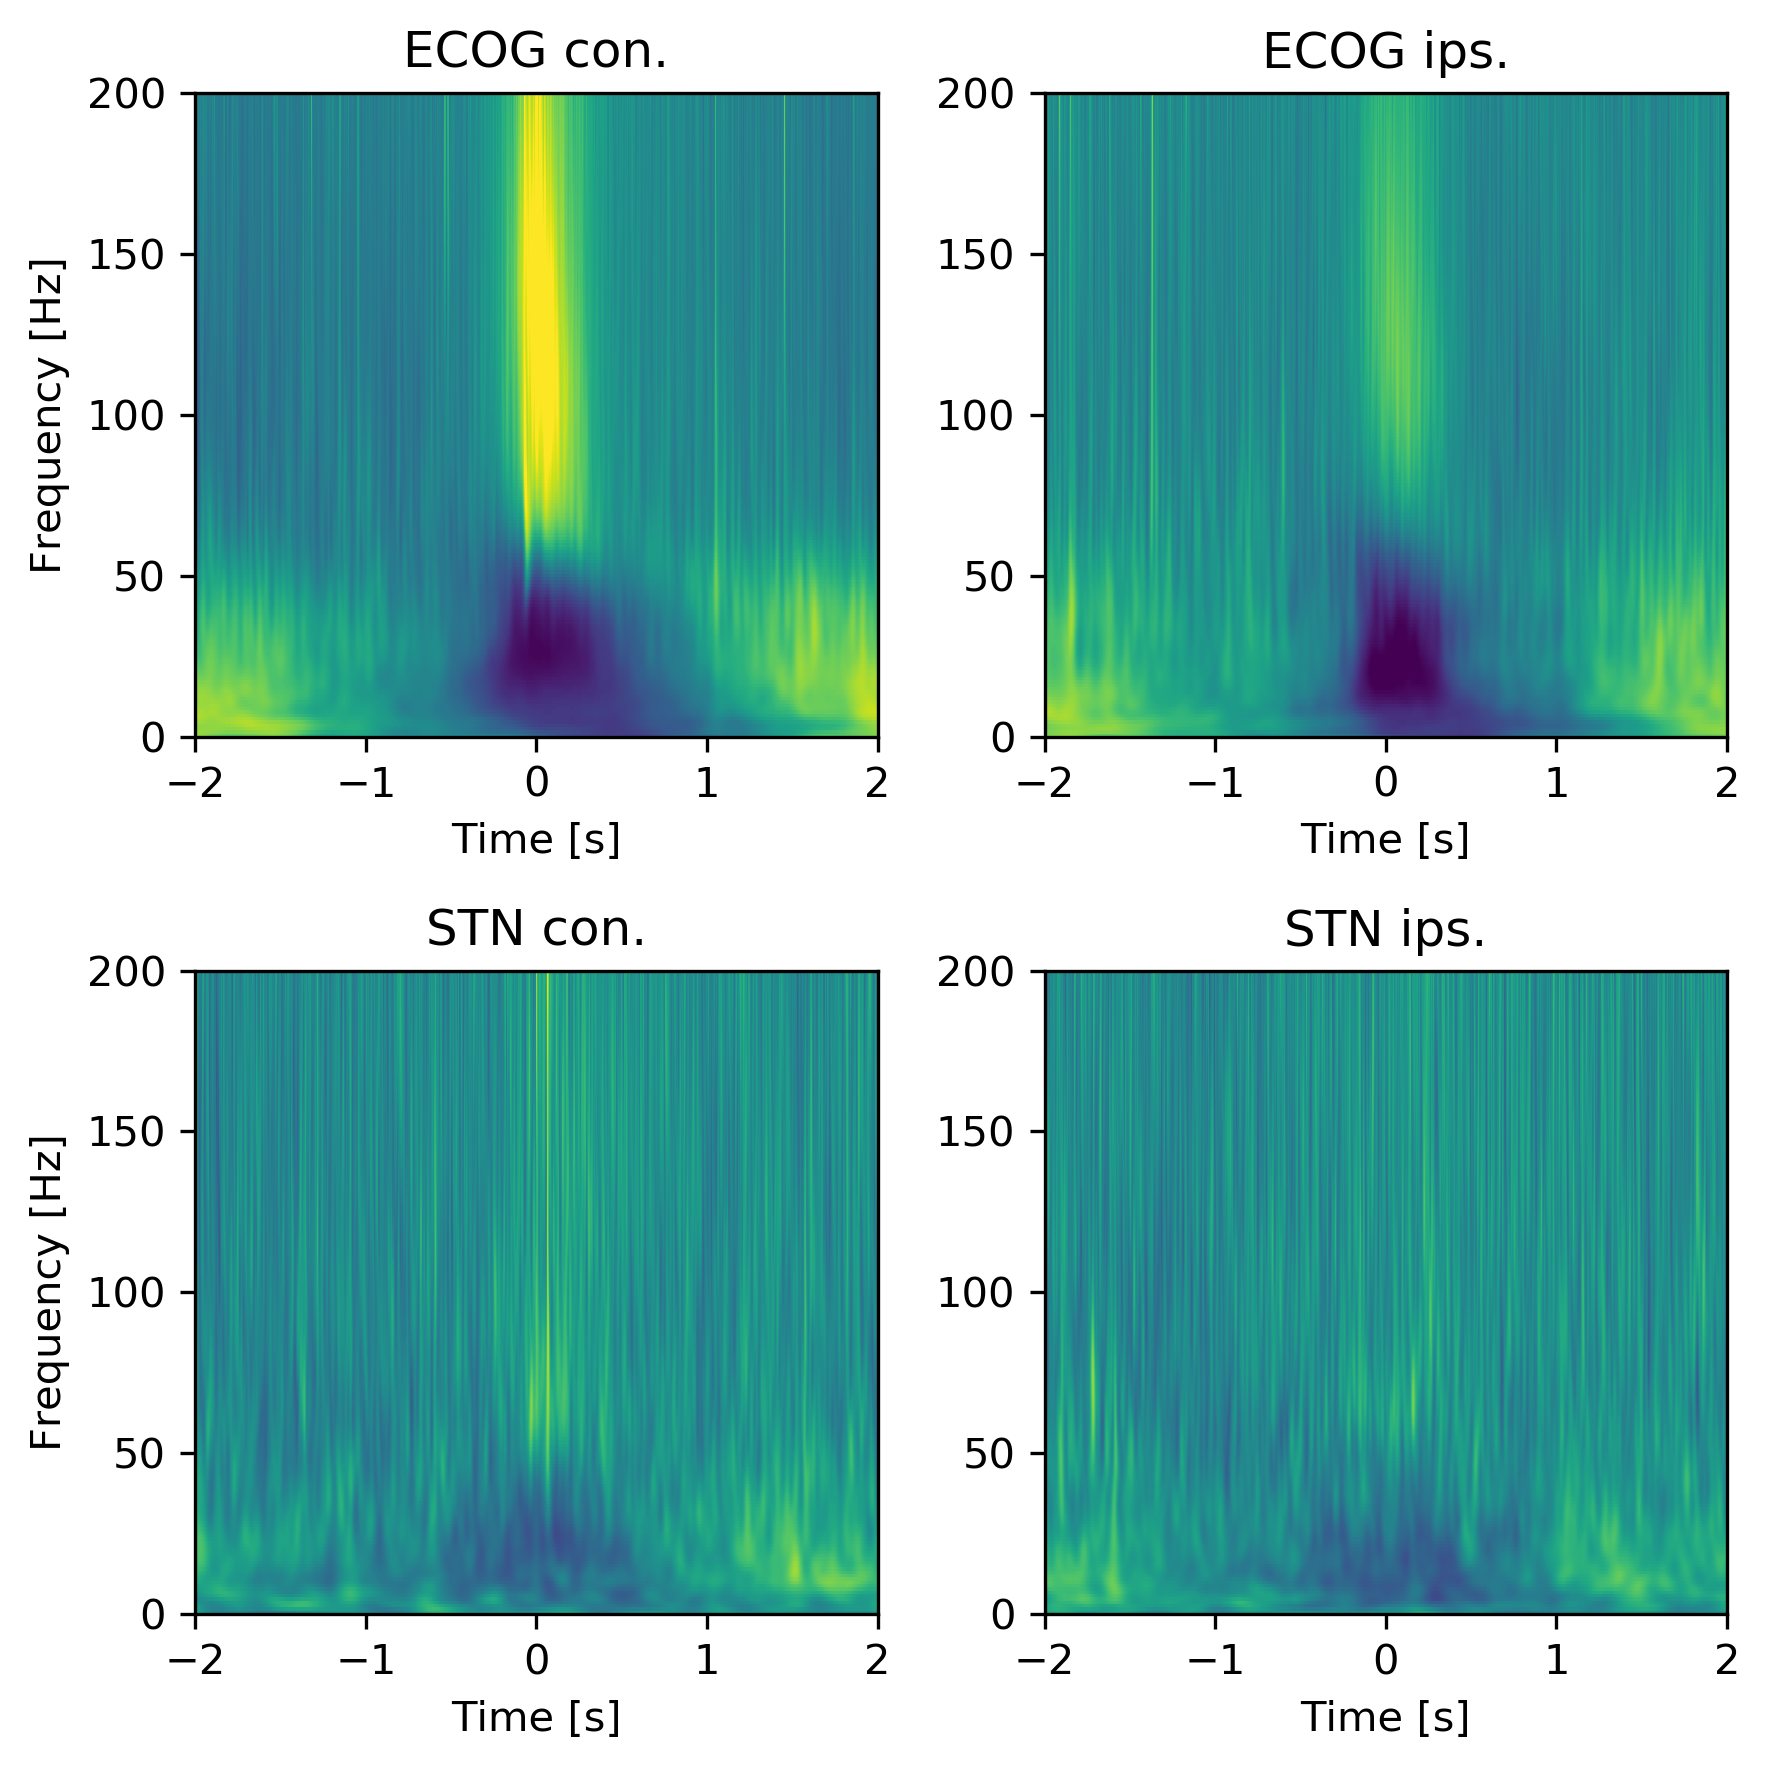

In [35]:
title = ['ECOG con.', 'ECOG ips.', \
        'STN con.', 'STN ips.']
plt.figure(figsize=(6,6), dpi=300)
for idx, dat_ in enumerate([ECOG_CON, ECOG_Ips, STN_CON, STN_Ips]):
    plt.subplot(2,2,idx+1)
    plt.imshow(dat_, aspect='auto', extent=[-2,2,200,0])#, cmap='hot')
    #cbar = plt.colorbar()
    #cbar.set_label('Normalized spectral power [VAR]')
    plt.clim(-1.5,1.5)
    plt.gca().invert_yaxis()
    plt.title(title[idx])
    if idx == 0 or idx == 2:
        plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()

In [28]:
files_STN_Con

['ECOG_False_Con_True_sub_000_ch_ECOG_RIGHT_0.npy',
 'ECOG_False_Con_True_sub_000_ch_ECOG_RIGHT_1.npy',
 'ECOG_False_Con_True_sub_000_ch_ECOG_RIGHT_2.npy',
 'ECOG_False_Con_True_sub_000_ch_ECOG_RIGHT_3.npy',
 'ECOG_False_Con_True_sub_000_ch_ECOG_RIGHT_4.npy',
 'ECOG_False_Con_True_sub_000_ch_ECOG_RIGHT_5.npy',
 'ECOG_False_Con_True_sub_000_ch_STN_RIGHT_0.npy',
 'ECOG_False_Con_True_sub_000_ch_STN_RIGHT_1.npy',
 'ECOG_False_Con_True_sub_000_ch_STN_RIGHT_2.npy',
 'ECOG_False_Con_True_sub_000_ch_STN_RIGHT_3.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_0.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_1.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_10.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_11.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_12.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_13.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_14.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_15.npy',
 'ECOG_False_Con_True_sub_001_ch_ECOG_LEFT_16.npy',
 'ECOG_False_Con_T

In [29]:
files_STN_Ips

['ECOG_False_Con_False_sub_000_ch_ECOG_RIGHT_0.npy',
 'ECOG_False_Con_False_sub_000_ch_ECOG_RIGHT_1.npy',
 'ECOG_False_Con_False_sub_000_ch_ECOG_RIGHT_2.npy',
 'ECOG_False_Con_False_sub_000_ch_ECOG_RIGHT_3.npy',
 'ECOG_False_Con_False_sub_000_ch_ECOG_RIGHT_4.npy',
 'ECOG_False_Con_False_sub_000_ch_ECOG_RIGHT_5.npy',
 'ECOG_False_Con_False_sub_000_ch_STN_RIGHT_0.npy',
 'ECOG_False_Con_False_sub_000_ch_STN_RIGHT_1.npy',
 'ECOG_False_Con_False_sub_000_ch_STN_RIGHT_2.npy',
 'ECOG_False_Con_False_sub_000_ch_STN_RIGHT_3.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_0.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_1.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_10.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_11.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_12.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_13.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_14.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_15.npy',
 'ECOG_False_Con_False_sub_001_ch_ECOG_LEFT_16.npy',

In [23]:
ECOG_CON.shape

(193, 4000)

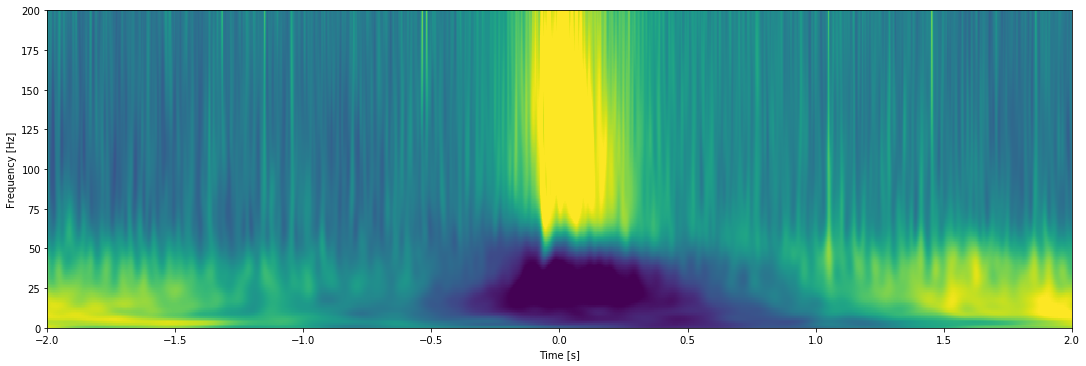

In [25]:
plt.figure(figsize=(15,5))
#plt.subplot(1,6,ch_idx+1)
plt.imshow(ECOG_CON, aspect='auto', extent=[-2,2,200,0])
#plt.colorbar()
plt.clim(-1,1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()